# Прогнозирование KERAS

In [1]:
# TensorFlow и tf.keras
import tensorflow as tf
from tensorflow import keras

# Вспомогательные библиотеки
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
from time import time
import matplotlib.ticker as tkr

from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn import metrics

ImportError: Traceback (most recent call last):
  File "C:\Users\irina\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "C:\Users\irina\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "C:\Users\irina\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "C:\Users\irina\anaconda3\lib\imp.py", line 242, in load_module
    return load_dynamic(name, filename, file)
  File "C:\Users\irina\anaconda3\lib\imp.py", line 342, in load_dynamic
    return _load(spec)
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: Не найден указанный модуль.


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/errors

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

Задача не просто сделать прогнозы по предыдущим дням - нам необходимо создать окно из этих предыдущих дней (возьмем 30), а прогнозировать будем 30+1 день

In [2]:
# Считаем данные - у нас массив данных по акциям Alphbet (google) с сайта yahoo finannce за последние 5 лет
data = pd.read_csv("https://query1.finance.yahoo.com/v7/finance/download/GOOG?period1=1446854400&period2=1604707200&interval=1d&events=history&includeAdjustedClose=true")[::-1]

In [3]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
1258,2020-11-06,1753.949951,1772.430054,1740.349976,1761.750000,1761.750000,1660900
1257,2020-11-05,1781.000000,1793.640015,1750.510010,1763.369995,1763.369995,2065800
1256,2020-11-04,1710.280029,1771.364990,1706.030029,1749.130005,1749.130005,3570900
1255,2020-11-03,1631.780029,1661.699951,1616.619995,1650.209961,1650.209961,1661700
1254,2020-11-02,1628.160034,1660.770020,1616.030029,1626.030029,1626.030029,2535400


In [4]:
# Даты были в обратном порядке, поэтому отсортируем их
data.sort_index(inplace=True)

In [5]:
data.shape

(1259, 7)

У нас 1259 наблюдений (дней, за которые есть данные за последние 5 лет)

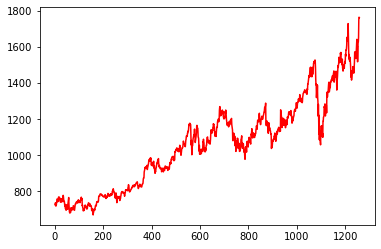

In [6]:
# Нам важна цена закрытия, посмотрим на ее динамику за последние 5 лет:
plt.plot(data.Close, color='r')

## Подготовим данные

In [7]:
# нарезаем с шагом 1 данные по 30 дней для X (данные, на которых мы предсказываем)
# и 30+1 день для Y (то, что именно мы предсказываем)
# Получаем много "окон" из 30 дней и 1 дня после, на которых будем тренировать сет
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [8]:
# У нас 7 столбцов, но прогнозировать мы будем только цену закрытия
dataset = np.array(data.Close)

In [9]:
# Чтобы прогнозировать непрерывные случайные величины, формат чисел должен быть float, а не int
dataset = dataset.astype('float32')

In [10]:
# Изменим размерность матрицы
dataset = np.reshape(dataset, (-1, 1))

In [11]:
# Приведем все значения в диапазон от 0 до 1 (стандартиизация)
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [12]:
# Определим размеры тренировочной и тестовой выборки
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size

In [13]:
# Разрежем данные на тренировочную и тестовую выборки
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [14]:
# Количество дней, на основе которых мы делаем прогноз (размер окна)
look_back = 30

In [15]:
# Используем написанную ранее функцию для создания данных для обучения нейронной сети
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [16]:
# Для tensorflow нужна следующая размерность [количество выборок, количество дней в окне, количество признаков]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

Для такого типа прогнозов (прогноз следующей даты по имеющимся данным за предыдущие дни) один из лучших вариантов - LSTM архитектура рекуррентной нейронной сети

## Построим необходимую модель нейросети: будем использовать LSTM

In [17]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping

In [18]:
# Построим необходимую модель нейросети: будем использовать LSTM

# Предсказываем временные ряды
model = Sequential()
model.add(LSTM(120, input_shape=(X_train.shape[1], X_train.shape[2])))

# Нужно для исключения переобучения: "выбрасываем" на некоторых итерациях случайные нейроны
model.add(Dropout(0.2))

# На выходе должен быть прогноз по 1 дню
model.add(Dense(1))

# Функция ошибок mse, оптимизатор ADAM
model.compile(loss='mse',optimizer='adam')

# Начнем процесс тренировки модели:
history = model.fit(X_train, Y_train, epochs=500, batch_size=32, verbose=1, shuffle=False)

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
976/976 [==============================] - 1s 1ms/sample - loss: 0.0022
Epoch 2/500
976/976 [==============================] - 0s 490us/sample - loss: 0.0026
Epoch 3/500
976/976 [==============================] - 0s 424us/sample - loss: 0.0015
Epoch 4/500
976/976 [==============================] - 0s 500us/sample - loss: 0.0013
Epoch 5/500
976/976 [==============================] - 0s 501us/sample - loss: 0.0013
Epoch 6/500
976/976 [==============================] - 0s 426us/sample - loss: 0.0011
Epoch 7/500
976/976 [==============================] - 0s 507us/sample - loss: 0.0011
Epoch 8/500
976/976 [==============================] - 0s 493us/sample - loss: 8.7083e-04
Epoch 9/500
976/976 [======

## Прогноз

In [19]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [20]:
# Мы до этого сжали данные в отрезок от 0 до 1, теперь вернем их в исходное состояние
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

In [21]:
# Выведем ошибки модели
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 12.643452662230498
Train Root Mean Squared Error: 16.811119825446287
Test Mean Absolute Error: 25.177489369229484
Test Root Mean Squared Error: 33.51486361877304


In [55]:
trainPredictPlot = np.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[27:len(train_predict)+27, :] = train_predict

testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
testPredictPlot[(len(data) - test_predict.shape[0]):len(data), :] = test_predict

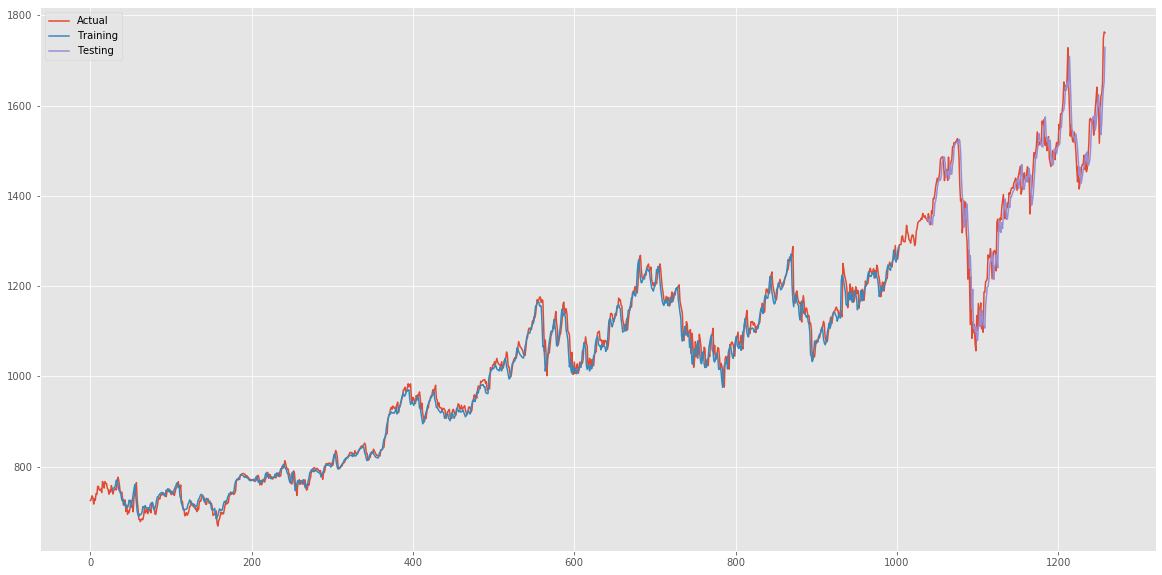

In [56]:
plt.plot(pd.DataFrame(data, columns=["Close"], index=data.index).Close, label='Actual')
plt.plot(pd.DataFrame(trainPredictPlot, columns=["Close"], index=data.index).Close, label='Training')
plt.plot(pd.DataFrame(testPredictPlot, columns=["Close"], index=data.index).Close, label='Testing')
plt.legend(loc='best')
plt.show()

# ARIMA

In [129]:
# Import libraries
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Defaults
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams.update({'font.size': 12})
plt.style.use('ggplot')

In [130]:
# Load the data
# Считаем данные - у нас массив данных по акциям Alphbet (google) с сайта yahoo finannce за последние 5 лет
data = pd.read_csv("https://query1.finance.yahoo.com/v7/finance/download/GOOG?period1=1446854400&period2=1604707200&interval=1d&events=history&includeAdjustedClose=true")

In [131]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-11-09,730.200012,734.710022,719.429993,724.890015,724.890015,2069800
1,2015-11-10,724.400024,730.590027,718.500000,728.320007,728.320007,1608000
2,2015-11-11,732.460022,741.000000,730.229980,735.400024,735.400024,1366400
3,2015-11-12,731.000000,737.799988,728.645020,731.229980,731.229980,1837200
4,2015-11-13,729.169983,731.150024,716.729980,717.000000,717.000000,2075500


In [132]:
from pandas.tseries.offsets import BDay
data['Date'] =pd.to_datetime(data['Date'])
data.index= data['Date']

In [133]:
data = data[['Close']].copy()
# data['Date']=pd.to_datetime(data['Date'], format='%Y-%m-%d')
# data.set_index(['Date'], inplace=True)

#Даты были в обратном порядке, по
data.sort_index(inplace= True)

In [134]:
data.head()

,Close
Date,
2015-11-09,724.890015
2015-11-10,728.320007
2015-11-11,735.400024
2015-11-12,731.229980
2015-11-13,717.000000


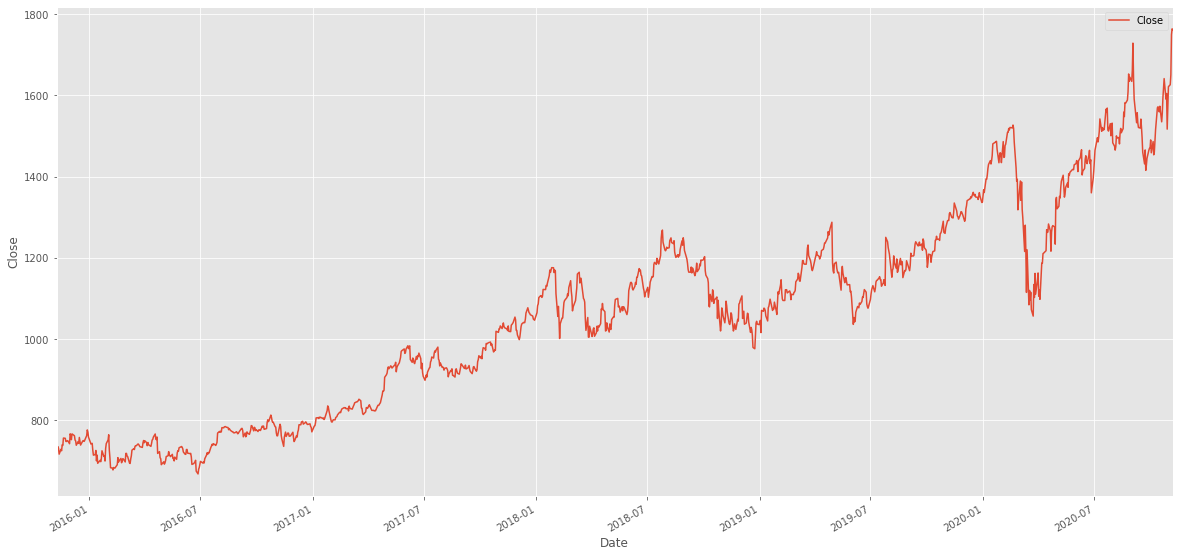

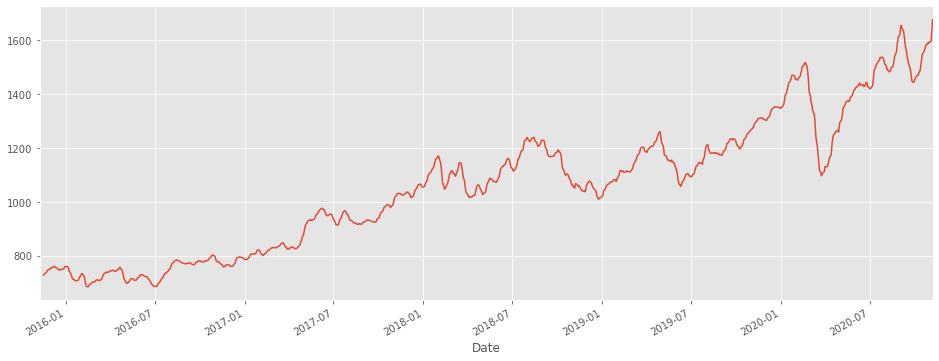

In [135]:
# Plot the data
data.plot()
plt.ylabel('Close')
plt.xlabel('Date')
plt.show()
data.rolling(7).mean()['Close'].plot(figsize=(16,6))

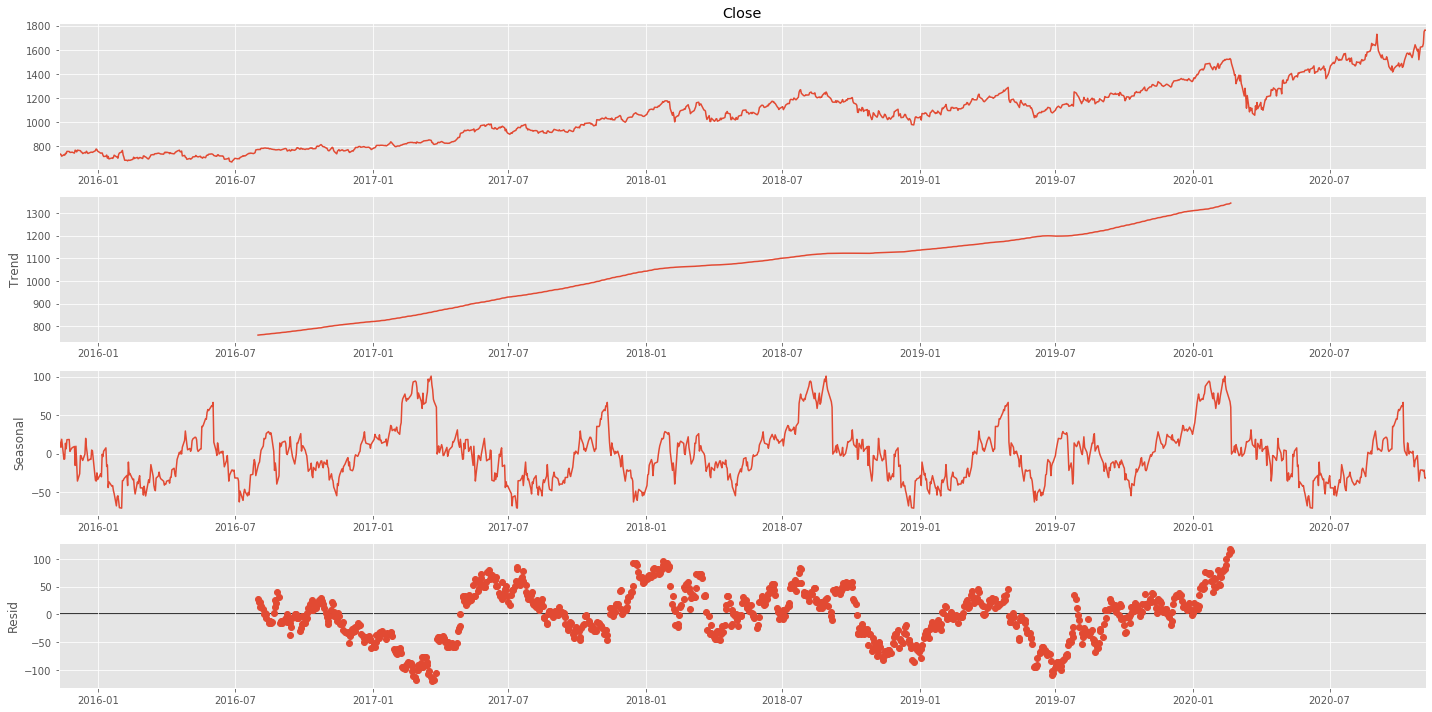

In [143]:
import statsmodels.api as sm
result=sm.tsa.seasonal_decompose(data['Close'],model='add',freq=365);
fig=result.plot()
plt.show()

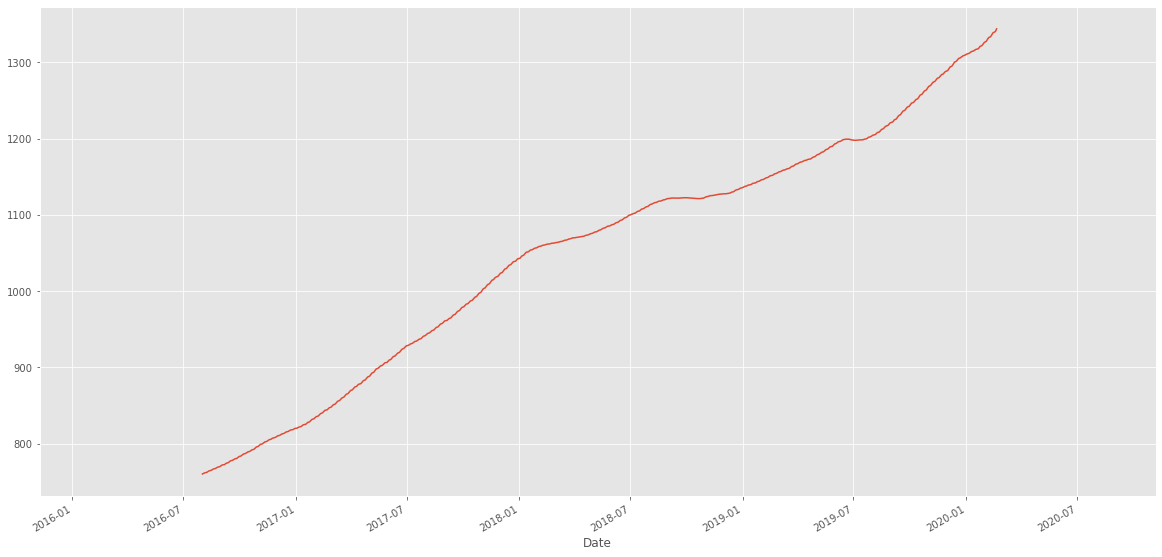

In [144]:
result.trend.plot()

In [145]:
print(result.trend)
print(result.seasonal)
print(result.resid)
print(result.observed)

Date
2015-11-09   NaN
2015-11-10   NaN
2015-11-11   NaN
2015-11-12   NaN
2015-11-13   NaN
2015-11-16   NaN
2015-11-17   NaN
2015-11-18   NaN
2015-11-19   NaN
2015-11-20   NaN
2015-11-23   NaN
2015-11-24   NaN
2015-11-25   NaN
2015-11-27   NaN
2015-11-30   NaN
2015-12-01   NaN
2015-12-02   NaN
2015-12-03   NaN
2015-12-04   NaN
2015-12-07   NaN
2015-12-08   NaN
2015-12-09   NaN
2015-12-10   NaN
2015-12-11   NaN
2015-12-14   NaN
2015-12-15   NaN
2015-12-16   NaN
2015-12-17   NaN
2015-12-18   NaN
2015-12-21   NaN
              ..
2020-09-28   NaN
2020-09-29   NaN
2020-09-30   NaN
2020-10-01   NaN
2020-10-02   NaN
2020-10-05   NaN
2020-10-06   NaN
2020-10-07   NaN
2020-10-08   NaN
2020-10-09   NaN
2020-10-12   NaN
2020-10-13   NaN
2020-10-14   NaN
2020-10-15   NaN
2020-10-16   NaN
2020-10-19   NaN
2020-10-20   NaN
2020-10-21   NaN
2020-10-22   NaN
2020-10-23   NaN
2020-10-26   NaN
2020-10-27   NaN
2020-10-28   NaN
2020-10-29   NaN
2020-10-30   NaN
2020-11-02   NaN
2020-11-03   NaN
2020-11-0

In [146]:
df_reconstructed = pd.concat([result.seasonal, result.trend, result.resid, result.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed.tail(20)

,seas,trend,resid,actual_values
Date,,,,
2020-10-12,-2.286541,NaN,NaN,1569.150024
2020-10-13,13.994670,NaN,NaN,1571.680054
2020-10-14,8.419651,NaN,NaN,1568.079956
2020-10-15,-0.406776,NaN,NaN,1559.130005
2020-10-16,2.879156,NaN,NaN,1573.010010
2020-10-19,0.804956,NaN,NaN,1534.609985
2020-10-20,3.220277,NaN,NaN,1555.930054
2020-10-21,-6.920087,NaN,NaN,1593.310059
2020-10-22,-17.001752,NaN,NaN,1615.329956


In [147]:
df_reconstructed.dropna(axis=0,inplace=True)
df_reconstructed

,seas,trend,resid,actual_values
Date,,,,
2016-08-01,-15.926971,760.443781,28.363195,772.880005
2016-08-02,-12.553298,760.821507,22.801797,771.070007
2016-08-03,-10.736692,761.215973,22.700711,773.179993
2016-08-04,-2.481088,761.589480,12.501593,771.609985
2016-08-05,4.461784,761.981316,15.776872,782.219971
2016-08-08,9.943864,762.499014,9.317132,781.760010
2016-08-09,19.872760,763.002055,1.385195,784.260010
2016-08-10,19.254144,763.525727,1.900123,784.679993
2016-08-11,19.888923,764.038165,0.922888,784.849976


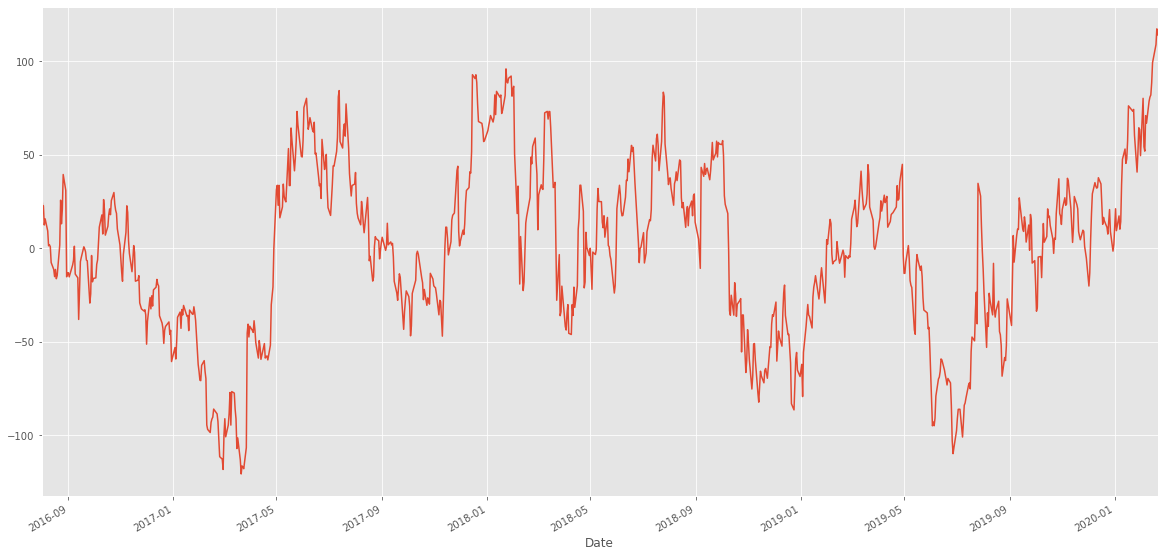

In [148]:
df_reconstructed.resid.plot()

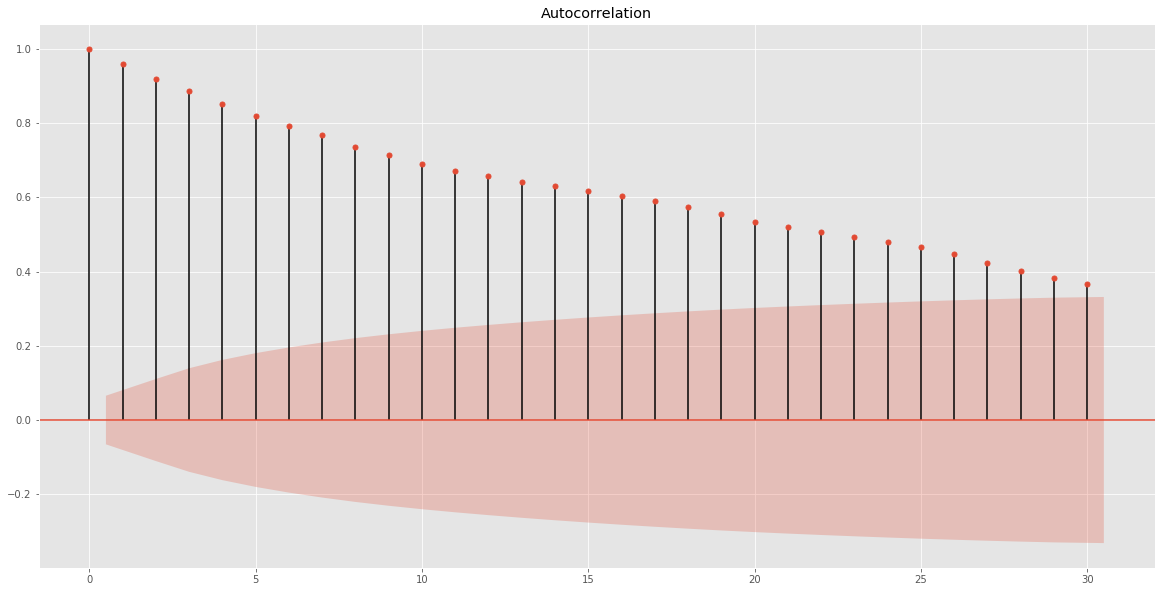

In [149]:
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(df_reconstructed.resid.values)
pyplot.show()

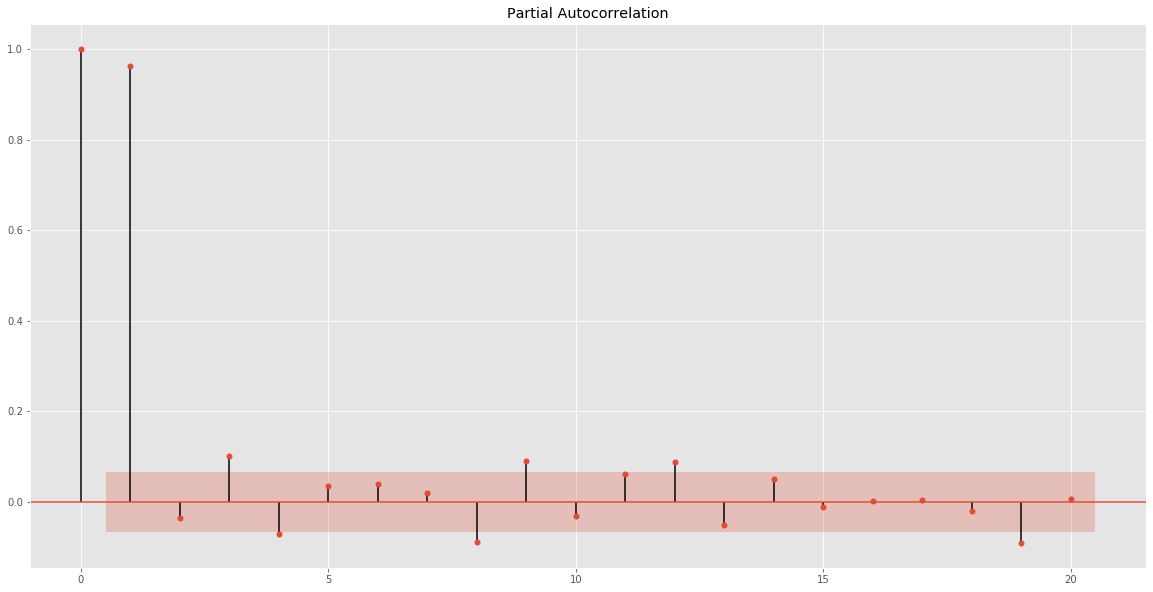

In [150]:
plot_pacf(df_reconstructed.resid, lags=20)
pyplot.show()

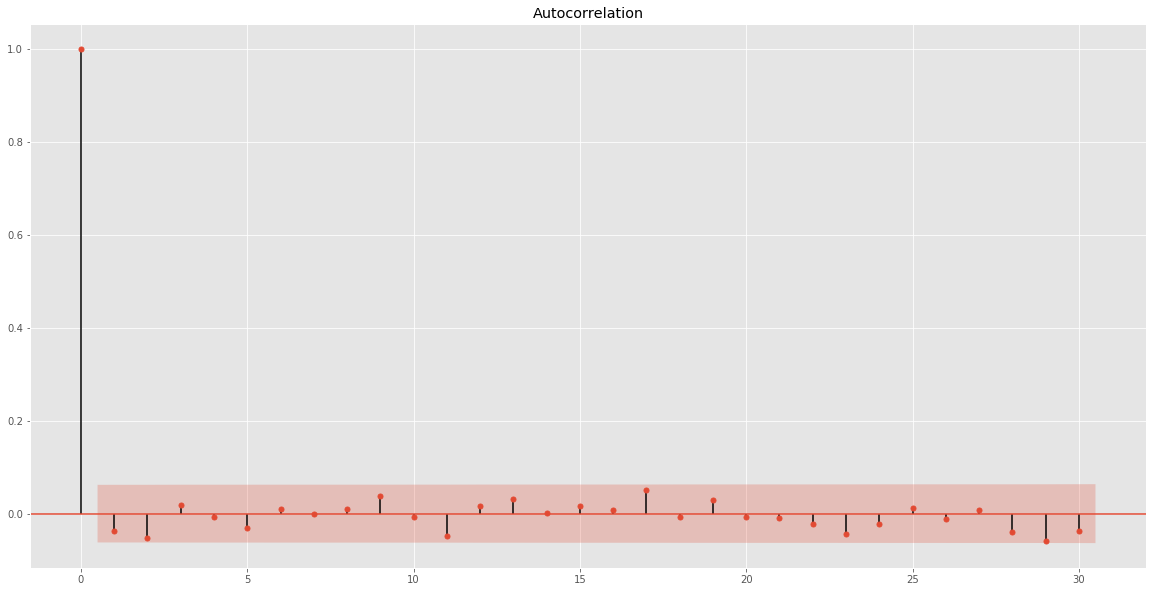

In [151]:
plot_acf(np.random.randn(1000))
pyplot.show()

In [176]:
train_size=int(len(data) *0.80)
test_size = int(len(data)) - train_size
train_data, test_data = data[0:train_size], data[train_size:len(data)]

In [187]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# fit model
model = ARIMA(train_data, order=(1, 1, 1))

model_fit = model.fit()

In [188]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                 1006
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -4119.406
Method:                       css-mle   S.D. of innovations             14.525
Date:                Tue, 01 Dec 2020   AIC                           8246.813
Time:                        05:59:47   BIC                           8266.468
Sample:                             1   HQIC                          8254.281
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.5638      0.311      1.811      0.070      -0.046       1.174
ar.L1.D.Close     0.8580      0.070     12.201      0.000       0.720       0.996
ma.L1.D.Close    -0.9038      0.058    -15.496      0.000      -1.018      -0.790
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1655           +0.0000j            1.1655            0.0000
MA.1            1.1064           +0.0000j            1.1064            0.0000
-----------------------------------------------------------------------------
"""

In [189]:
start_params = model_fit.params

In [190]:
# Определите параметры d и q, чтобы они принимали любое значение от 0 до 1
q = d = range(0, 2)
# Определите параметры p, чтобы они принимали любое значение от 0 до 3
p = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Генерация всех различных комбинаций троек p, q и q
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Примеры комбинаций параметров для сезонной ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Примеры комбинаций параметров для сезонной ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [191]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue

In [192]:
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))

The smallest AIC is 8088.431269590416 for model SARIMAX(1, 1, 1)x(0, 1, 1, 12)


In [193]:
# Let's fit this model
mod = sm.tsa.statespace.SARIMAX(train_data,
                                order=SARIMAX_model[AIC.index(min(AIC))][0],
                                seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

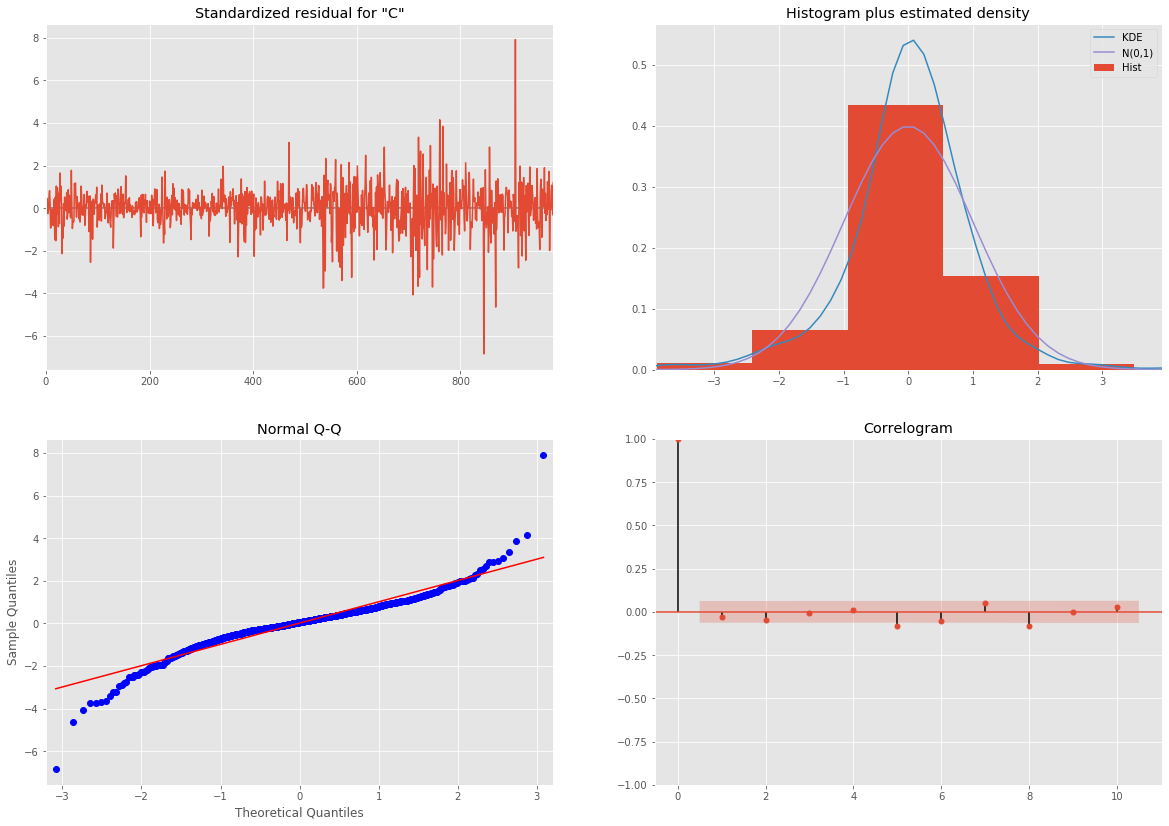

In [194]:
results.plot_diagnostics(figsize=(20, 14))
plt.show()

In [234]:
pred0 = results.get_prediction(start=520, dynamic=False)
pred0_ci = pred0.conf_int()

In [241]:
pred1 = results.get_prediction(start=520, dynamic=True)
pred1_ci = pred1.conf_int()
pred2 = results.get_prediction(start=624, dynamic=False)
pred2_ci = pred2.conf_int()

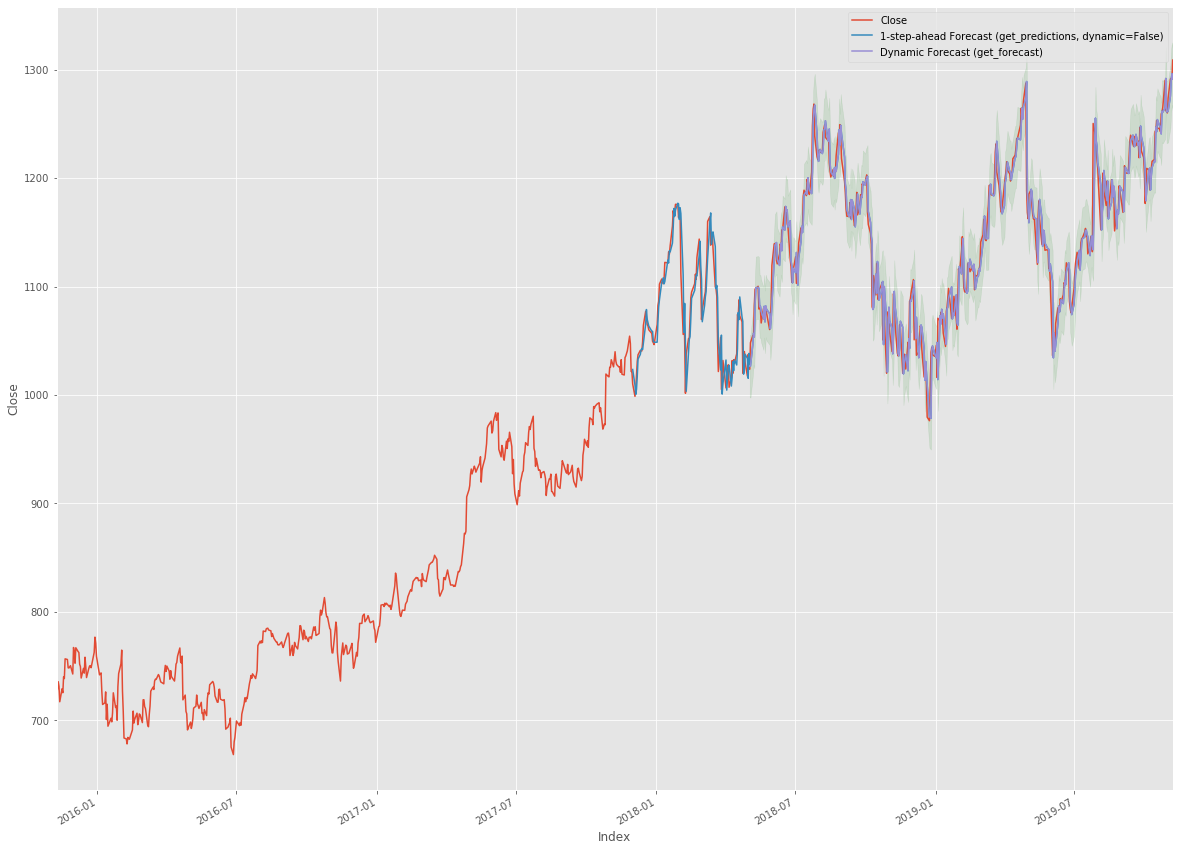

In [243]:
ax = data.plot(figsize=(20, 16))
pred0.predicted_mean.plot(ax=ax, label='1-step-ahead Forecast (get_predictions, dynamic=False)')
# pred1.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_predictions, dynamic=True)')
pred2.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_forecast)')
ax.fill_between(pred2_ci.index, pred2_ci.iloc[:, 0], pred2_ci.iloc[:, 1], color='g', alpha=.1)
plt.ylabel('Close')
plt.xlabel('Index')
plt.legend()
plt.show()

In [244]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,median_absolute_error, mean_squared_log_error,mean_absolute_error, r2_score

In [274]:
print('Train Mean Absolute Error:', mean_absolute_error(train_data[train_size-len(pred2.predicted_mean):train_size], pred2.predicted_mean))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(train_data[train_size-len(pred2.predicted_mean):train_size], pred2.predicted_mean)))

Train Mean Absolute Error: 13.177833491504025
Train Root Mean Squared Error: 18.676954084470818


Таким образом, LSTM справился чуть лучше, его значения:
- Train Mean Absolute Error: 12.643452662230498
- Train Root Mean Squared Error: 16.811119825446287